# 信用卡数字识别

## 项目流程如下：

1.读取处理参考图像，进行轮廓检测(检测外轮廓)

2.得到当前轮廓的外接矩形，并将模板中的外接矩形切割出来，得到0-9对应的模板图片，并resize

3.使用形态学操作对信用卡图片进行处理，得到轮廓

4.根据矩形轮廓的长宽比挑选出信用卡的数字矩形框，并resize

5.使用for循环依次检测

## 第0步：导入需要的包，定义需要的函数

In [1]:
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plt#Matplotlib是RGB
%matplotlib inline 

### 定义图片展示函数

In [2]:
# opencv自带的弹窗展示图片
def cv_show(name,img):
    cv2.imshow(name,img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
# plt.imshow可将图片展示在下方，但是颜色是RGB格式，opencv默认BGR，需要转换一下,顺便加个标题
def imshow(name,img,GRAY):#参数1：自定义图片标题  参数2：要显示的图像 参数3：“RGB”彩图  “GRAY”灰度图
    if(GRAY=="RGB"):
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.imshow(imgRGB)
    if(GRAY=="GRAY"):
        plt.imshow(img,cmap='gray') 
    if(GRAY=="BIN"):
        plt.imshow(img,cmap='binary')  
    plt.title(name)  
    plt.show()

### 自己定义的轮廓排序的函数

In [4]:
# 对轮廓进行排序
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
 
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
 
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts] #用一个最小的矩形，把找到的形状包起来x,y,h,w
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),key=lambda b: b[1][i], reverse=reverse))
 
    return cnts, boundingBoxes

### 自己定义的重新调整大小的函数

In [5]:

def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation=inter)
    return resized

## 第1步：参考图像的读取和处理：

参考图像如下，因为银行卡号主要只有0~9这几个数字，为了方便识别数字，我们直接利用这张图片里的数值作为匹配样式：
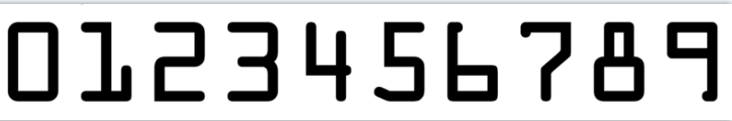

所以下面我们要做的事很明显，就是要将其中每个数字单独隔开方便与实际银行卡上的数字匹配。

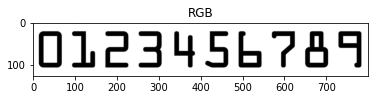

In [6]:
img=cv2.imread("ocr_a_reference.png")#读取图片，图片在代码文件旁边可以直接写图片名字
imshow('RGB',img,"RGB")

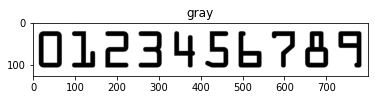

In [7]:
ref = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)#转换为灰度图
imshow('gray',ref,"GRAY")

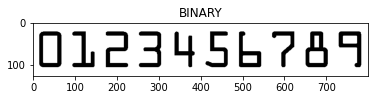

In [8]:
# 轮廓检测输入的是二值图像  所以需要二值图像
ret,thresh1 = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)#设置图像阈值进行二值化
imshow("BINARY",thresh1,"BIN")

In [9]:
ref_, refCnts, hierarchy = cv2.findContours(thresh1, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)#轮廓检测

mode:轮廓检索模式
- RETR_EXTERNAL ：只检索最外面的轮廓；
- RETR_LIST：检索所有的轮廓，并将其保存到一条链表当中；
- RETR_CCOMP：检索所有的轮廓，并将他们组织为两层：顶层是各部分的外部边界，第二层是空洞的边界;
- RETR_TREE：检索所有的轮廓，并重构嵌套轮廓的整个层次;

method:轮廓逼近方法
- CHAIN_APPROX_NONE：以Freeman链码的方式输出轮廓，所有其他方法输出多边形（顶点的序列）。
- CHAIN_APPROX_SIMPLE:压缩水平的、垂直的和斜的部分，也就是，函数只保留他们的终点部分。

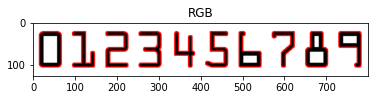

(10,)


In [10]:
img1=img.copy()
cv2.drawContours(img1,refCnts,-1,(0,0,255),2) 
imshow('RGB',img1,'RGB')#cv_show('img',img)
print (np.array(refCnts,dtype=object).shape)#显示有几个轮廓

## 第2步：得到当前轮廓的外接矩形，并将模板中的外接矩形切割出来，得到0-9对应的模板图片，并resize

In [11]:
# 对轮廓进行排序
# 分析模板图片 0：位置1  1：位置2  2：位置3  ..
# 返回的是排序完的轮廓
refCnts = sort_contours(refCnts, method="left-to-right")[0] #排序，从左到右，从上到下
digits = {} # 保存模板中每个数字对应的数值

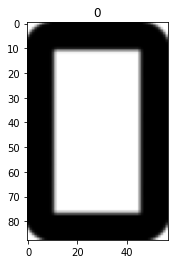

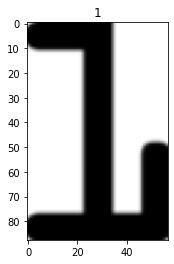

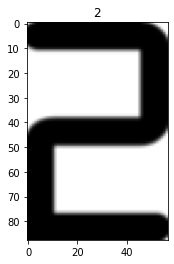

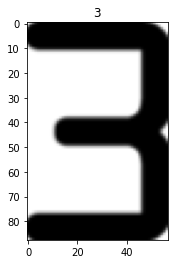

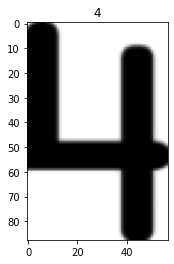

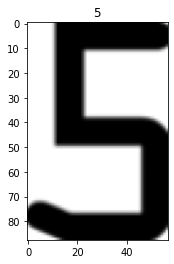

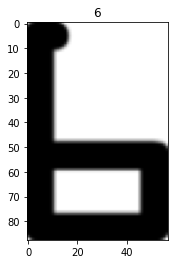

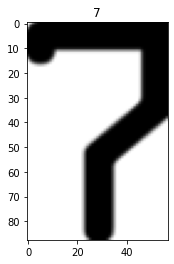

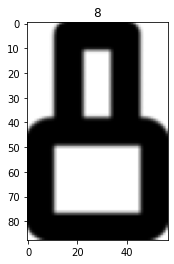

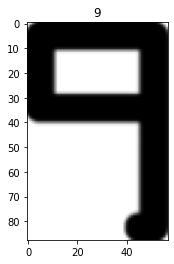

In [12]:
#遍历每一个轮廓
for(i,c) in enumerate(refCnts):
    #计算外接矩形并且resize成合适大小
    (x,y,w,h)=cv2.boundingRect(c)
    roi=ref[y:y+h,x:x+w] # 获取区域
    roi=cv2.resize(roi,(57,88))
    #每一个数字对应一个模板
    digits[i]=roi
    imshow(i,roi,"GRAY")

## 第3步：使用形态学操作对信用卡图片进行处理，得到轮廓

In [13]:
# 初始化卷积核  -- 两个
# 大小的确定是根据实际的任务进行确定的
rectKernal = cv2.getStructuringElement(cv2.MORPH_RECT,(9,3))
sqKernal = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
print(rectKernal)
print(sqKernal)

[[1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]]
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


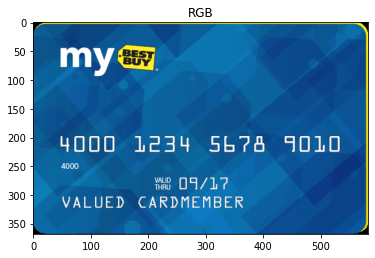

In [14]:
# 读取输入图像，预处理
image = cv2.imread('credit_card_01.png')
imshow("RGB",image,'RGB')

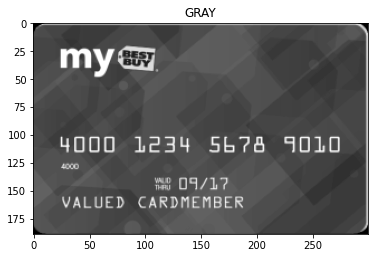

In [15]:
image = resize(image,width=300)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#cv_show('gray',gray)
imshow("GRAY",gray,'GRAY')

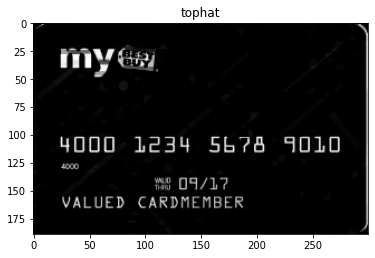

In [16]:
# 礼帽操作  突出更明亮的区域
tophat = cv2.morphologyEx(gray,cv2.MORPH_TOPHAT,rectKernal)# 这个函数可以方便的对图像进行一系列的膨胀腐蚀组合
imshow("tophat",tophat,'GRAY')

(189, 300)


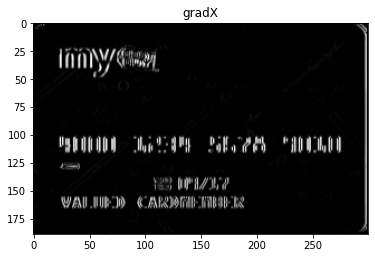

In [17]:
# 使用Sobel算子转换为轮廓
gradX = cv2.Sobel(tophat,ddepth = cv2.CV_32F,dx=1,dy=0,ksize=-1)
gradX = np.absolute(gradX)# 绝对值
(minVal , maxVal) = (np.min(gradX),np.max(gradX))
gradX = (255 * ((gradX-minVal)/(maxVal-minVal))) # 归一化 
gradX = gradX.astype('uint8') # 归一化后要把数据改成uint8的形式

print(np.array(gradX).shape)
imshow("gradX",gradX,'GRAY')

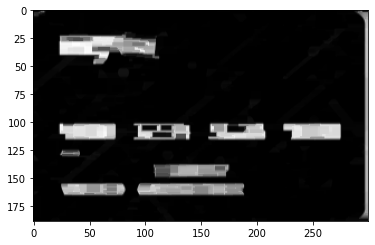

In [18]:
# 如何将数字连在一起成为块 ---信用卡中数字分成4块
# 通过闭操作（先膨胀，再腐蚀） --将数字连在一起
gradX = cv2.morphologyEx(gradX,cv2.MORPH_CLOSE,rectKernal)
imshow("",gradX,"GRAY")

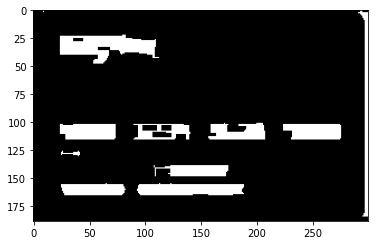

In [19]:
# THRESH_OTSU自动寻找合适的的阈值， 适合双峰 需把阈值参数设为0(0是和THRESH_OTSU搭配的)
thresh = cv2.threshold(gradX,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] 
imshow("",thresh,"GRAY")

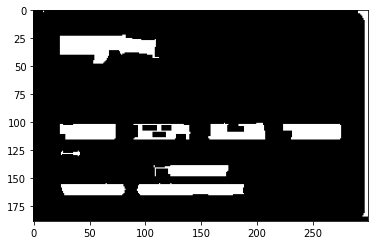

In [20]:
# 再来闭操作
thresh = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,sqKernal)
#cv_show('thresh',thresh)
plt.imshow(thresh,cmap = 'gray')

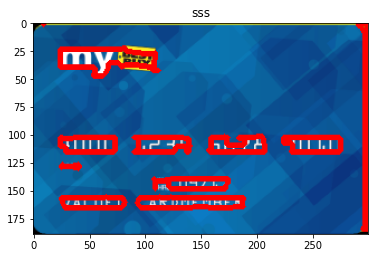

In [21]:
# 计算轮廓
thresh_, threshCnts, hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
# 得到后在原图中进行展示
cnts = threshCnts
cur_img = image
cv2.drawContours(cur_img,cnts,-1,(0,0,255),3)
imshow('sss',cur_img,"RGB")


## 第4步：根据矩形轮廓的长宽比挑选出信用卡的数字矩形框，并resize

In [22]:
locs = []

# 遍历轮廓 通过比例选择出合适的留下来

for (i,c) in enumerate(cnts):
    # 计算矩形
    (x,y,w,h) = cv2.boundingRect(c)
    ar = w / float(h) #根据外接矩形的长宽比来筛选有用的矩形，并将其添加到元组中
    print(w)
    
    # 选择合适的区域，根据实际任务来，这里的基本都是四个数字一组
    if ar > 2.5 and ar < 4.0:
        if (w >40 and w < 55) and (h > 10 and h <20):
            # 符合的留下来
            locs.append((x, y, w, h))

# 符合的轮廓进行排序
locs = sorted(locs,key=lambda x:x[0], reverse = False)
print(locs)


96
58
67
17
52
51
50
51
89
9
1
[(24, 102, 50, 14), (90, 102, 51, 14), (157, 101, 51, 15), (224, 102, 52, 14)]


## 第5步：使用for循环依次检测

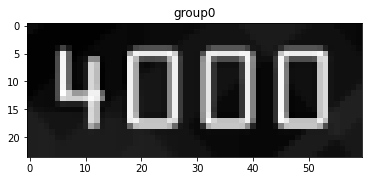

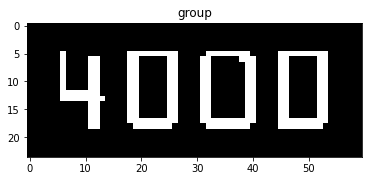

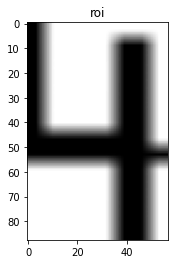

0
0
0
3
4
4
4
4
4
4


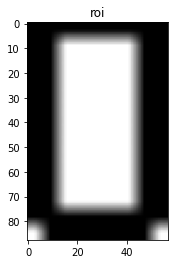

0
0
0
0
0
0
0
0
0
0


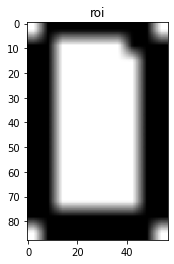

0
0
0
0
0
0
0
0
0
0


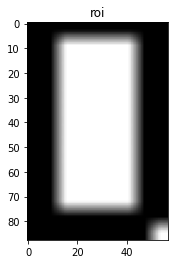

0
0
0
0
0
0
0
0
0
0


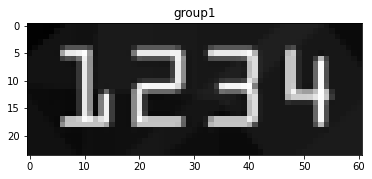

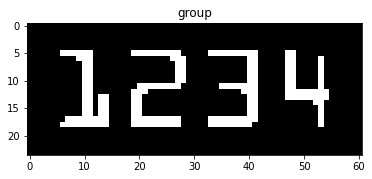

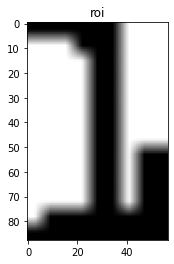

0
1
1
1
1
1
1
1
1
1


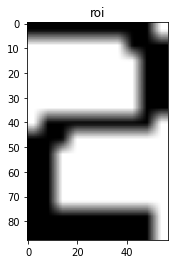

0
0
2
2
2
2
2
2
2
2


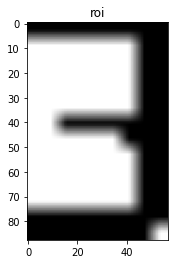

0
0
2
3
3
3
3
3
3
3


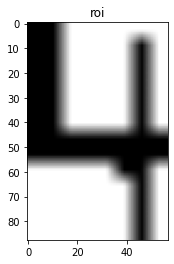

0
0
0
0
4
4
4
4
4
4


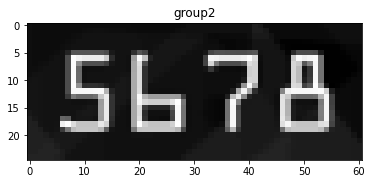

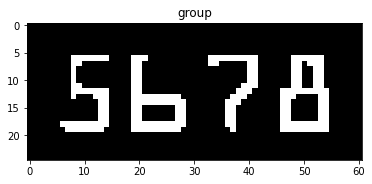

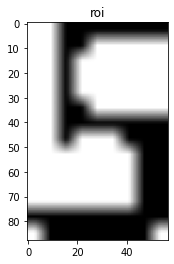

0
1
1
3
3
5
5
5
5
5


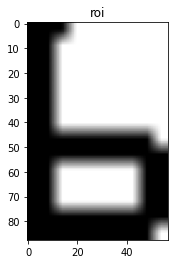

0
0
0
0
0
0
6
6
6
6


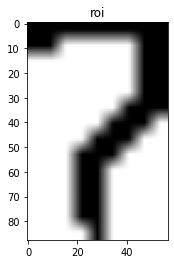

0
1
2
3
3
3
3
7
7
7


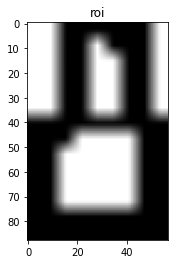

0
0
2
2
2
5
5
5
8
8


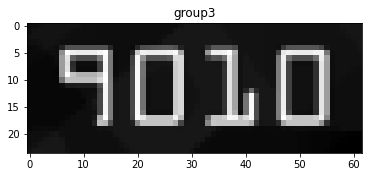

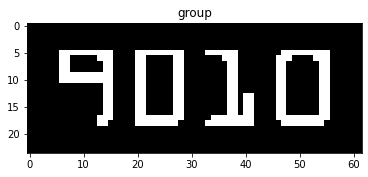

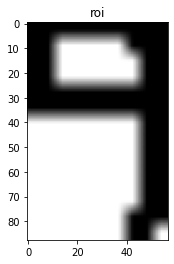

0
0
0
0
0
0
0
0
0
9


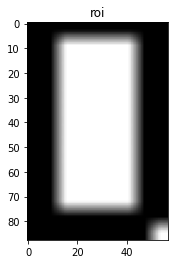

0
0
0
0
0
0
0
0
0
0


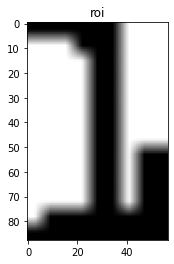

0
1
1
1
1
1
1
1
1
1


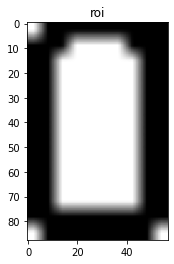

0
0
0
0
0
0
0
0
0
0


In [23]:
# 现在已经选出合适的轮廓了。需要把各个轮廓提出来，最后进行分别的识别操作
# 通过遍历轮廓中的每一个数字，寻找合适的参数

output = []
for(i,(gx,gy,gw,gh)) in enumerate(locs):
    
    groupOutput = []

    # 根据坐标提取每一个组
    group = gray[gy - 5:gy + gh + 5, gx - 5:gx + gw + 5]# 对轮廓的区域多拿一些  扩大取轮廓
    imshow('group'+str(i),group,"GRAY")
    # 预处理
    group = cv2.threshold(group,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] 
    imshow('group',group,"GRAY")
    
    # 计算四组轮廓中每一组轮廓中的小轮廓
    group_,digitCnts,hierarchy = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    digitCnts = sort_contours(digitCnts,method="left-to-right")[0]

    # 计算每一组中每个数的数值
    for c in digitCnts:
        # 找到当前数值的轮廓，resize成合适的大小
        (x,y,w,h) = cv2.boundingRect(c)
        roi = group[y:y+h,x:x+w]
        roi = cv2.resize(roi,(57,88)) # 与模板的大小相同
        roi=255-roi
        imshow('roi',roi,"GRAY")
        
    # 计算匹配得分
        scores  = []
    
    # 在模板中计算每一个得分
        for (digit,digitROI)in digits.items():#在模板预处理中建立了数值的字典类型,一个为索引、一个为值
           #匹配，返回与之匹配度最高的数值  每次都会有匹配度 选择最高的
           
            result=  cv2.matchTemplate(roi,digitROI,cv2.TM_CCOEFF) 
            (_,score,_,_) = cv2.minMaxLoc(result)#做10次匹配，取最大值（注意：取最大值还是最小值跟选取的模板匹配方法有关）
            
            scores.append(score)
            print(str(np.argmax(scores)))
        # 得到合适的数字        
        groupOutput.append(str(np.argmax(scores)))
       
    # 画框
    cv2.rectangle(image,(gx-5,gy-5),(gx+gw+5,gy+gh+5),(0,0,255),1)
    # 写出来 
    cv2.putText(image,"".join(groupOutput),(gx,gy-15),cv2.FONT_HERSHEY_SIMPLEX,0.65,(0,0,255),2)
    
    output.extend(groupOutput)





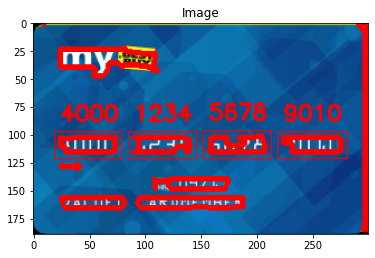

Credit Card #: 4000123456789010


In [24]:
imshow("Image",image,"RGB")    
print("Credit Card #: {}".format("".join(output)))